**Universidad de los Andes** — Facultad de Ingeniería

Autores: **Andrés Vega**, **David Méndez-Acuña**

## **Reinforced Logo**

### **Contexto**

Logo es un lenguaje de programación creado por Seymour Papert y Wallace Feurzeig en 1966. Se trata de un lenguaje concebido con fines educativos que se usa para introducir nociones básicas de algorítmica a niños en cursos tempranos de educación primaria. 

El principio de Logo se basa en una tortuga que se controla a partir de instrucciones simples de movimiento —avanzar, girar a la derecha o izquierda, retroceder, etc.—.  La tortuga deja un trazo sobre el plano sobre el que se mueve. El objetivo es entonces enseñarle al niño a programar mientras dibuja. 

### **Objetivo**

El objetivo del proyecto es enseñarle a Logo a dibujar **figuras rectangulares**. En particular, a lo largo de este documento presentaremos una solución para enseñarle a Logo a dibujar dos figuras: un cuadrado simple, y un caracol cuadrado como se ve en las imágenes a continuación.

<br>
<center>
    <img src="https://raw.githubusercontent.com/Sulfur0/turtle-drawing/master/entregable/target-figures.png" width="600">
</center>
<center>
Figura 1. Pipeline de ejecución para resolver el problema de generación automática de muestrarios de colores a partir de obras de arte.
</center>
<br>

### **Generalidades de la solución**

La solución que proponemos consta de dos etapas: **entrenamiento** y **dibujo**. Durante la fase de entrenamiento, entrenamos a Logo a partir de un sistema de recompensas que explicaremos más adelante. Como resultado de esta primera fase, obtenemos una matriz de q-valores que contiene también la política óptima que guiará a Logo durante el dibujo. Durante la fase de dibujo, Logo seguirá la política optima y dejará un trazo sobre el canvas mientras sigue esa política. 

Para esto, las posibles acciones de Logo corresponden a sus capacidades de movimiento. Originalmente, Logo soporta cuatro movimientos: forward, backward, left, right. Los dos primeros permiten avanzar y retroceder tantos pasos como se indique en el parámetro. Los dos últimos le permiten a la tortuga girar a la izquierda o a la derecha en el ángulo indicado por el parámetro. En este proyecto, **simplificaremos estos movimientos** para así limitar el movimiento de la tortuga a cuatro direcciones. Entonces, las acciones posibles serán: **up**, **down**, **left**, y **right**. Cada una de las acciones avanzará Logo hacia la dirección indicada por la acción en la cantidad de pasos indicada por el parámetro. 

### **Sistema de recompensas:** una recompensa por cada trazo



Para entrenar Logo decidimos de seguir una estrategia de una recompensa por trazo. Entonces, tendremos tantas recompensas como trazos. El entrenamiento se hará también por trazos; entrenaremos logo a seguir cada trazo por separado y la fase de dibujo integrará lo aprendido en los entrenamientos de los trazos.

Para ilustrar lo anterior, considere el ejemplo de un ciadrado. El esquema de aprendizaje por trazos se estructura de la siguiente manera.

- **Primer entrenamiento:** Le enseñamos a Logo a ir desde su punto de origen (en el vértice superior-izquierdo del canvas) al primer vértice del cuadrado. Durante este trayecto, le pedimos a Logo que mantena el lápiz arriba de manera que no deje trazo durante este primer recorrido que no hace parte de la figura. 

- **Segundo entrenamiento:** Entrenamos Logo para ir desde el primer vértice del cuadrado hacia el segundo vértice. Durante el trayecto, le pedimos a Logo que baje el lápiz de manera que deje un trazo durante su recorrido. 

- **Tercer, cuarto, y quinto entrenamiento:** Durante el resto de los entrenamientos, se sigue el mismo procedimiento que para el entrenamiento anterior. Es importante mencionar que en cada entrenamiento el punto de inicio de Logo cambia por el vértice del trazo inmediatamente anterior.

### **Fase de entrenamiento**

A continuación presentamos el código correspondiente a la fase de entrenamiento de Logo.

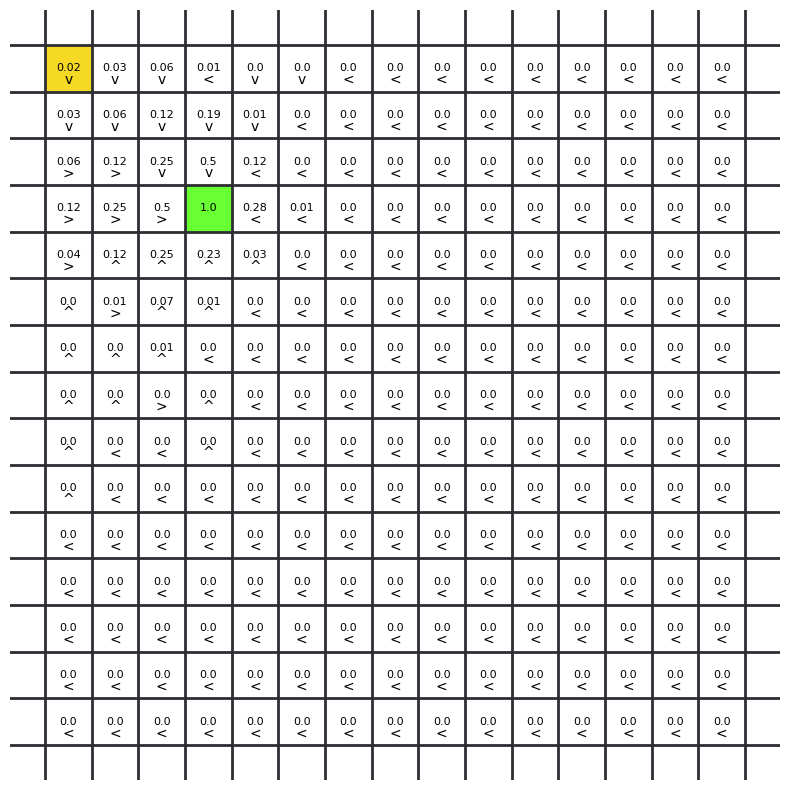

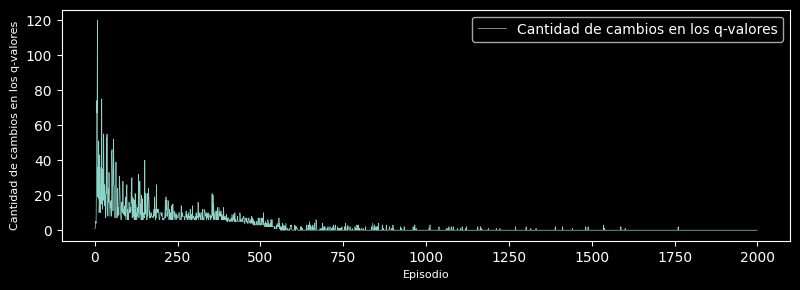

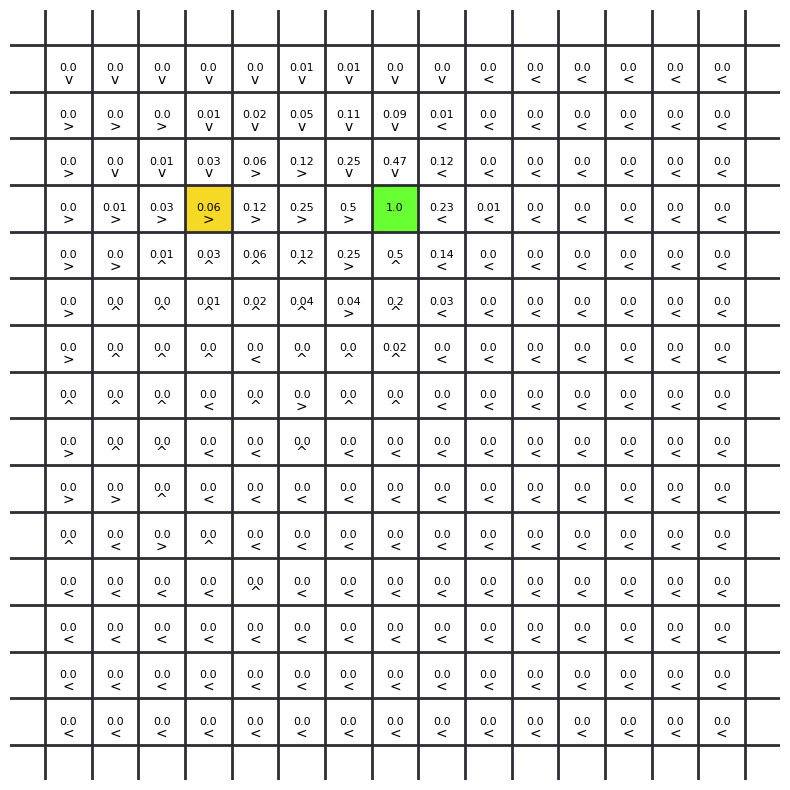

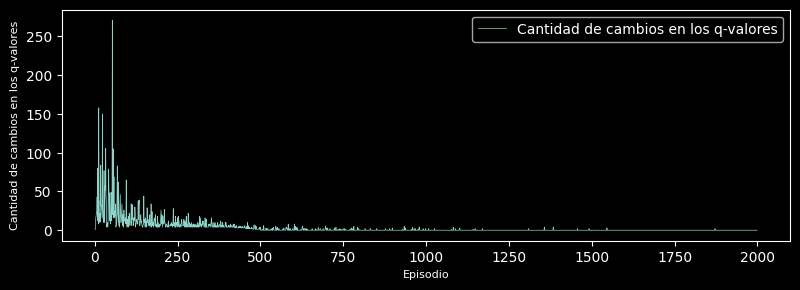

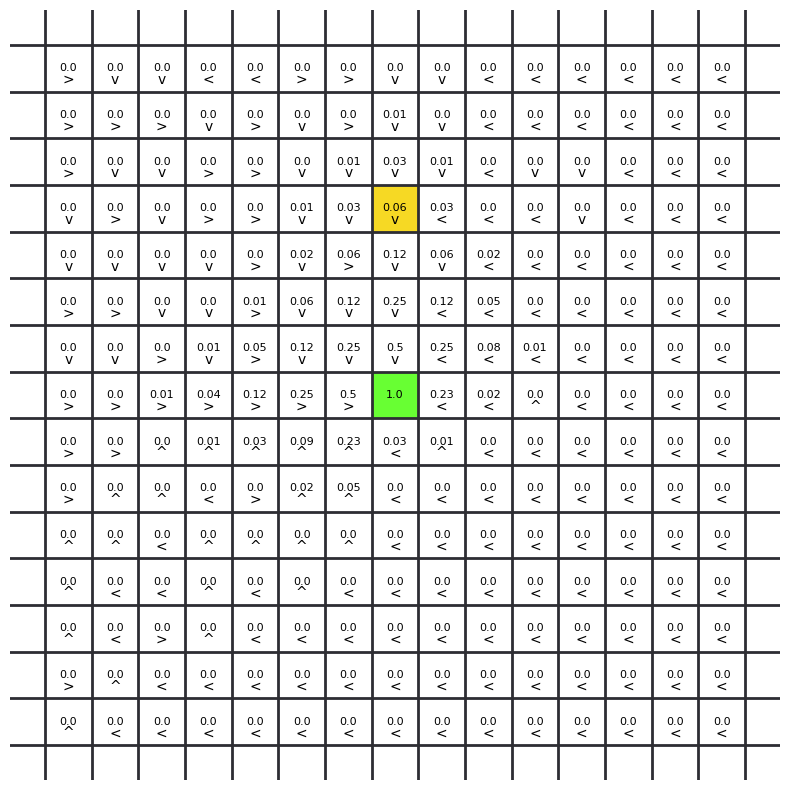

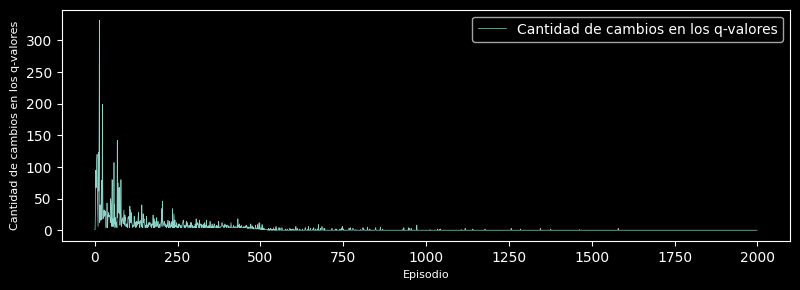

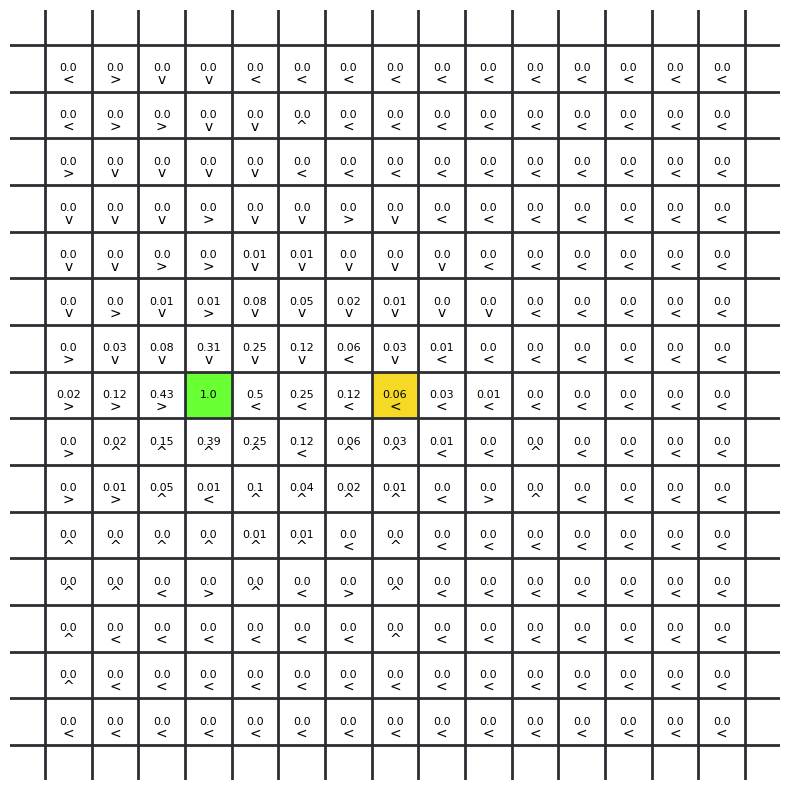

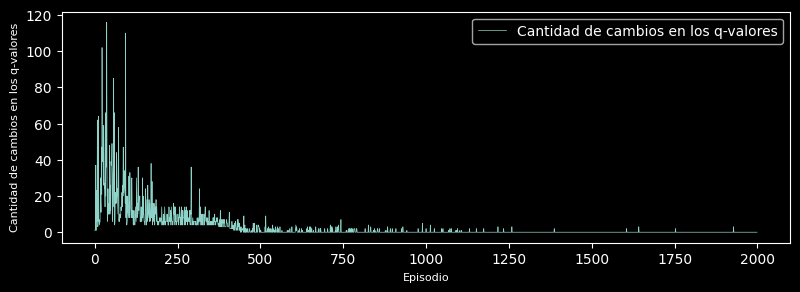

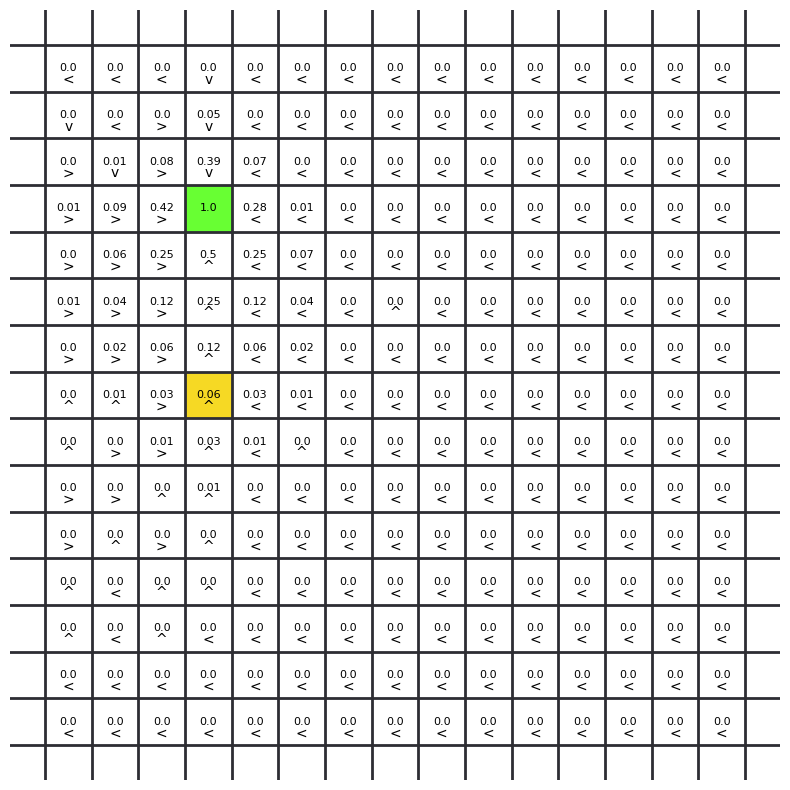

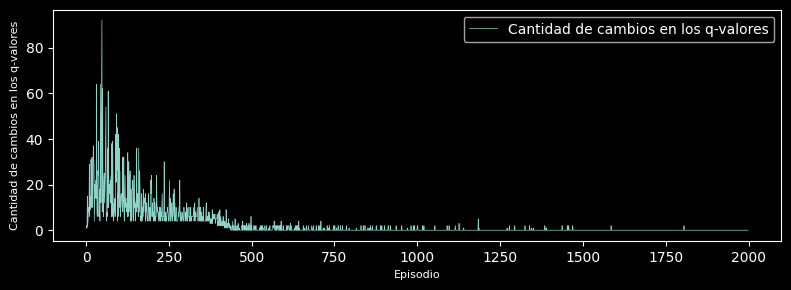

In [1]:
%run environment.ipynb
%run agent.ipynb
%run rewards.ipynb

import matplotlib.pyplot as plt

def train(rewards_system):
    '''
    Este método entrena a Logo a partir del sistema de recompensas que entra por parámetro. 
    El resultado de este método corresponde a un objeto de la clase 'Agente' por cada
    uno de los trazos contenidos en el sistema de recompensas. 

    Entradas:
    ----------------
    - rewards_system -> array(str[][]): Sistema de recompensas que debe usarse para entrenar a Logo. 
      Se trata de un arreglo de matrices de strings. Se tienen tantas matrices como trazos en la
      figura que se quiere dibujar. Cada matriz tiene una recompensa positiva +1 (el objetivo) y un 
      punto de inicio S. No hay recompensas negativas.

    Salidas:
    ----------------
    - agents: array(Agent): Información necesaria para que Logo pueda dibujar. 
      Se trata de un arreglo de objetos de la clase Agente. Dicha clase contiene las matrices de q-valores
      que se usa para inferir la política óptima que Logo debe seguir durante el dibujo. 
    '''

    agents = []
    for board in rewards_system:
        environment = Environment(board)
        agent = Agent(environment, gamma=0.5, alpha=0.1, epsilon=0.9, episodes=2000)
        stats = agent.run()
        actions, values = agent.actions_values()
        environment.plot_action(actions, values)
        environment.plot_stats(stats)
        agents += [agent, ]

    return agents


rewards_system = Rewards().square(size=Size.L)
#rewards_system = Rewards().snail(size=Size.L)
agents = train(rewards_system)

In [2]:
import turtle 

class Logo:

    def __init__(self, step_size=5, draw_rewards_only=False):

        # Configuración de la tortuga y de la pantalla
        self._turtle = turtle.Turtle()
        self._turtle.penup()
        self._turtle.speed(30)
        self._turtle.left(90)
        self._turtle.pencolor("yellow")
        self._screen = turtle.Screen()
        self._screen.bgcolor("black")
        self.draw_rewards_only = draw_rewards_only
        self.step_size = step_size
        self._turtle.penup()

    
    def logo_coordinates(self, position):
        '''
        El sistema de coordenadas de la tortuga no es el mismo que el sistema de
        coordenadas del canvas. Mientras que la tortuga se mueve sobre un sistema
        cartesiano donde el origen está en el punto inferior izquerdo, el canvas
        inicia en el punto superior izquerdo. 
        
        Esto es porque el canvas esta representado
        como una matriz de python, la primera fila es la fila superior mientras que
        la primera columna es la de más a la izquirda. 
        
        Además, el canvas representa estados mientras que la posición de la tortuga
        debe tener en cuenta la distancia entre los estados que está definida por el 
        tamaño del paso. 

        Este método se encarga de hacer la transformación. Recibe como parámetro una
        coordenada en el sistema matricial (del canvas) y retorna la coordenada 
        correspondiente en el sistema cartesiado (usado por logo).
        '''
        i, j = position
        x = j * self.step_size
        y = i * self.step_size * -1
        return x, y
    

    def down(self):
        '''
        Mueve la torguga hacia abajo tantas unidades en self.step_size
        Si la posición de llegada de este movimiento tiene una recompensa,
        entonces la tortuga baja el lápiz para dibujar.
        '''
        self._turtle.right(180)
        self._turtle.forward(self.step_size)
        self._turtle.left(180)


    def up(self):
        '''
        Mueve la torguga hacia arriba tantas unidades en self.step_size
        Si la posición de llegada de este movimiento tiene una recompensa,
        entonces la tortuga baja el lápiz para dibujar.
        '''
        self._turtle.forward(self.step_size)
        

    def left(self):
        '''
        Mueve la torguga hacia la izquierda tantas unidades en self.step_size
        Si la posición de llegada de este movimiento tiene una recompensa,
        entonces la tortuga baja el lápiz para dibujar.
        '''
        self._turtle.left(90)
        self._turtle.forward(self.step_size)
        self._turtle.right(90)


    def right(self):
        '''
        Mueve la torguga hacia la derecha tantas unidades en self.step_size
        Si la posición de llegada de este movimiento tiene una recompensa,
        entonces la tortuga baja el lápiz para dibujar.
        '''
        self._turtle.right(90)
        self._turtle.forward(self.step_size)
        self._turtle.left(90)
        

    def go_to(self, position, draw=False):
        '''
        Este método hace que la tortuga salte hacia una posición diferente de la actual.
        El salto puede dejar trazo o no dependiendo del valor del parámetro 'draw'.
        '''
        logo_target = self.logo_coordinates(position)
        self._turtle.goto(logo_target[0], logo_target[1])


    
    def draw(self, agent, iterations=15, state=(0, 0), collision_strategy='stop', ignore_terminals=True):
        '''
        Este método usa la política en el agente para dibujar. El algoritmo de dibujo se basa en iteraciones, 
        cada iteración da un paso desde el estado actual en la dirección dictada por la política. 
        En algunos casos hay colisiones y es necesario desobedecer la política y saltar a otro lugar del tablero para 
        evitar ciclos infinitos. 

        Entradas:
        -----------

        - collision_strategy: Estrategia que se debe seguir en caso de colisiones. Dos opciones son posibles:
        'stop' que detiene la ejecución saliendo del ciclo de dibujo y del método, y 'jump' que hace que la tortuga
        salte a un punto aleatorio del tablero. 

        - ignore_terminals: Ignora el movimiento dictado por la política en un estado terminal. Esos movimientos
        no nos interesan cuando estamos calculando un trazo porque el estado terminal no debe cambiar dado que es el
        estado inicial de la siguiente iteración.
        '''
        pivot_state = agent.environment.initial_state
        print(f'Inicio un trazo en el estado: {agent.environment.initial_state}')
        actions, values = agent.actions_values()
        done = False
        while not done:            
            policy = actions[pivot_state]
            if policy == 'down':
                self.down()
            if policy == 'up':
                self.up()
            if policy == 'left':
                self.left()
            if policy == 'right':
                self.right()

            reward, new_state, done = agent.environment.do_action(policy)
            pivot_state = new_state
            


In [3]:
logo = Logo(step_size=15)

initial_trace = True
for agent in agents:
    if initial_trace:
        logo._turtle.penup()
    else:
        logo._turtle.pendown()
    logo.draw(agent=agent)
    initial_trace = False

2024-05-27 21:11:06.305 Python[50985:28403614] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Inicio un trazo en el estado: (0, 0)
Inicio un trazo en el estado: (3, 3)
Inicio un trazo en el estado: (3, 7)
Inicio un trazo en el estado: (7, 7)
Inicio un trazo en el estado: (7, 3)
